Script for creating and training the LSTM network models used to generate classical music.

Matilda Wikström

Jesper Larsson

Links to good stuff!

https://github.com/craffel/pretty-midi

https://towardsdatascience.com/generate-piano-instrumental-music-by-using-deep-learning-80ac35cdbd2e





In [41]:
#Imports
import torch
import pretty_midi
import numpy as np
import unicodedata
import re
import numpy as np
from random import shuffle, seed
import os
import io
import time
from tqdm import tnrange, tqdm_notebook, tqdm
# "Our code"
import preprocessing as pp
#import generatemidi as gm # Broken file, fix
import tokenizer as token
import generatemidi as gen

In [ ]:
# Using pretty_midi example
fs=30
dict_note = {}
midi_pretty_format = pretty_midi.PrettyMIDI('test.midi')
piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
piano_roll = piano_midi.get_piano_roll(fs=fs)
dict_note[0] = piano_roll

print(len(piano_roll[0]))

In [3]:
#Download the required data create folder structure
#Make sure we are in the correct folder

assert (os.path.basename(os.getcwd())=='LSTM-MusicGenerator'), "Wrong working dir"

#Download the MAESTRO Dataset
if not os.path.isfile('./maestro-v1.0.0-midi.zip'):
    !wget https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0-midi.zip

#Check if we have extracted the files
if not os.path.isdir('./maestro-v1.0.0-midi') and not os.path.isfile('./maestro-v1.0.0/LICENSE'):
    !unzip maestro-v1.0.0-midi.zip


/bin/sh: 1: wget: not found


In [42]:
# Preprocessing
nbr_of_songs = 10 #100
list_all_midi = pp.get_list_midi() # 
sampled_200_midi = list_all_midi[0:nbr_of_songs]
batch = 1
start_index = 0
note_tokenizer = token.NoteTokenizer()
import pretty_midi

for i in tqdm_notebook(range(len(sampled_200_midi))):
    dict_time_notes = token.generate_dict_time_notes(sampled_200_midi, batch_song=1, start_index=i, use_tqdm=False, fs=5)
    full_notes = token.process_notes_in_song(dict_time_notes)
    for note in full_notes:
        note_tokenizer.partial_fit(list(note.values()))
note_tokenizer.add_new_note('e') # Add empty notes



In [43]:
# Model
import torch.nn as nn
import torch.nn.functional as F

#Input dimension = 50
#Batch dimension = ? May be one, since we are putting them on 
#Hidden size, try different versions
   
input_size = 50
hidden_size = 200
num_layers = 1
is_bidirectional = True
dropout_rate = 0
batch_size = 1 #96 ### Should be 2085

seq_len = 50
unique_notes = note_tokenizer.unique_word #Used in our output layer to map



if is_bidirectional:
    num_directions = 2
else:
    num_directions = 1


class our_LSTM(torch.nn.Module):
    def __init__(self, h0, c0):
        super().__init__()
        self.hn = h0
        self.cn = c0
        
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout_rate, bidirectional=is_bidirectional)
        self.fc = torch.nn.Linear(num_directions * hidden_size, unique_notes)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, inp, use_softmax = False):
        out, (self.hn, self.cn) = self.lstm(inp, (self.hn, self.cn))
        out = self.fc(out)
        if use_softmax:
            out = self.softmax(out)
        out = out.permute(0,2,1)
        out = out.view(-1,unique_notes)
        
        return out, self.hn, self.cn
    


<IPython.core.display.Javascript object>


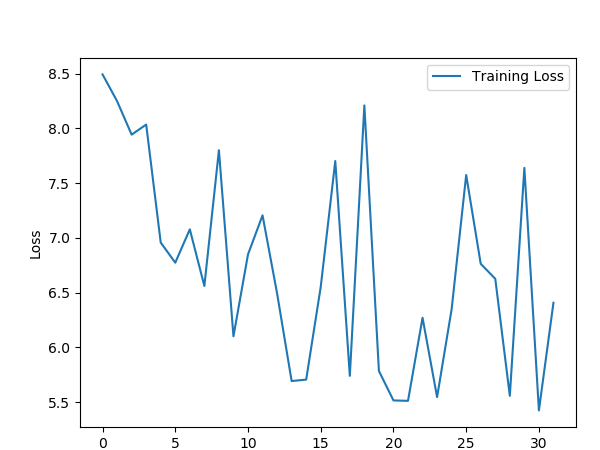

KeyboardInterrupt: 

In [44]:
from torch import optim
import matplotlib.pyplot as plt

# ---- variables
seq_len = 50 # input length here.
EPOCHS = 100
BATCH_SONG = 1 #16
BATCH_NNET_SIZE = 128 #96 # Our sequence length here.
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5

# ---- initialize model, states, loss fcn, optimizer 
hn = torch.zeros(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
cn = torch.zeros(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
model = our_LSTM(hn,cn)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

# ---- live plotting
%matplotlib notebook 
fig, axes = plt.subplots(1,1)
plt.ion()
fig.show()
fig.canvas.draw()
loss_vec = []


# ---- training loop
for epoch in tqdm_notebook(range(0,EPOCHS), desc='epoch'):
    batch_song = BATCH_SONG
    frame_per_second = FRAME_PER_SECOND
    shuffle(sampled_200_midi)
        
    for i in tqdm_notebook(range(0,len(sampled_200_midi),BATCH_SONG), desc=f'completed songs in epoch {epoch+1}'):
        inputs_nnet_large, outputs_nnet_large = token.generate_batch_song(
                sampled_200_midi, batch_song, start_index=i, fs=frame_per_second, 
                seq_len=seq_len, use_tqdm=False)

        trans_in = note_tokenizer.transform(inputs_nnet_large)
        trans_out = note_tokenizer.transform(outputs_nnet_large)
        #print("Max of out: ", max(trans_out), "Min of out :", min(trans_out))
        trans_out = trans_out - 1
        counter = 0
        model.hn.detach_() # reset hidden states
        model.cn.detach_()
        for j in range(0,len(trans_in)-BATCH_NNET_SIZE,BATCH_NNET_SIZE):
            counter += 1 
            input_tensor = trans_in[j:j+BATCH_NNET_SIZE]
            target_tensor = trans_out[j:j+BATCH_NNET_SIZE]
            #print("Max of target tensor: ", max(target_tensor), "Min of target tensor: ", min(target_tensor))

            input_tensor = torch.tensor(input_tensor,dtype=torch.float32)
            input_tensor = input_tensor[None,:,:] # Should be (seq_len, batch, input_size)
            input_tensor = input_tensor.permute(1,0,2)
            #print(input_tensor.shape)
            target_tensor = torch.tensor(target_tensor,dtype=torch.long).view(-1)
            pred, hn, cn = model(input_tensor)
            #print("Pred shape: ", pred.shape)
            #print("Target shape: ", target_tensor.shape)
            loss = loss_fn(pred,target_tensor)
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
        
        # -- plot
        loss_vec.append(loss)
        axes.clear()
        axes.plot(loss_vec)
        axes.set_xlabel('Batch')
        axes.set_ylabel('Loss')
        plt.legend(["Training Loss"])
        fig.canvas.draw()
    # -- save model every epoch
    if epoch+1 % 10 == 0:
        torch.save(model.state_dict(), f'lstm_{DATE}_{num_layers}layer_{hidden_size}hidden_ep{epoch+1}_3')
        np.save(f'loss_{DATE}_{num_layers}layer_{hidden_size}hidden_ep{epoch+1}_3', np.array(loss_vec))
    
    model.hn.detach_() # reset hidden states
    model.cn.detach_()





In [ ]:
# ---- save model and loss vector
# torch.save(model.state_dict(), 'lstm_20191021_10eps_100hidden')
np.save('loss_20191022_1layer_50hidden', np.array(loss_vec))

In [38]:


def generate_from_random(unique_notes, seq_len=50):
  generate = np.random.randint(0,unique_notes-1,seq_len).tolist()
  return generate
    
def generate_from_one_note(note_tokenizer, new_notes='35'):
  generate = [note_tokenizer.notes_to_index['e'] for i in range(49)]
  generate += [note_tokenizer.notes_to_index[new_notes]]
  return generate

def generate_notes(generate, model, unique_notes, max_generated=1000, seq_len=50):
  for i in tqdm_notebook(range(max_generated), desc='genrt'):
    test_input = np.array([generate])[:,i:i+seq_len]
    test_input = torch.tensor(test_input, dtype=torch.float32)
    test_inputa = test_input[None,:,:]
#     test_inputa = input_tensor.permute(1,0,2)
    #print(test_inputa.shape)
    #print(test_inputa)
    predicted_note, _, _ = model(test_inputa, use_softmax=True)
#     print(predicted_note)
    predicted_note = predicted_note.detach().numpy()
    predicted_note[predicted_note<0]=0
    prednote=predicted_note/np.sum(predicted_note)
    random_note_pred = np.random.choice(unique_notes, 1, replace=False, p=prednote[0])
    generate.append(random_note_pred[0])
    #generate.append(predicted_note.argmax(dim=1).item())
  return generate


def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=0, fs=8, max_generated=1000):
 generate = np.array(generate)
 generate[generate<1] = 1
 note_string = [note_tokenizer.index_to_notes[ind_note] for ind_note in generate]
 array_piano_roll = np.zeros((128,max_generated+1), dtype=np.int16)
 for index, note in enumerate(note_string[start_index:]):
   if note == 'e':
     pass
   else:
     splitted_note = note.split(',')
     for j in splitted_note:
       array_piano_roll[int(j),index] = 1
 generate_to_midi = pp.piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
 print("Tempo {}".format(generate_to_midi.estimate_tempo()))
 for note in generate_to_midi.instruments[0].notes:
   note.velocity = 100
 generate_to_midi.write(midi_file_name)


In [39]:
# ---- load saved model
hn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
cn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
model = our_LSTM(hn,cn)

model.load_state_dict(torch.load('lstm_20191022_1layer_200hidden_ep10'))

RuntimeError: Error(s) in loading state_dict for our_LSTM:
	size mismatch for fc.weight: copying a param with shape torch.Size([5756, 400]) from checkpoint, the shape in current model is torch.Size([4671, 400]).
	size mismatch for fc.bias: copying a param with shape torch.Size([5756]) from checkpoint, the shape in current model is torch.Size([4671]).

In [30]:
# ---- generate new music
max_generate = 200
input_len = 10
unique_notes = note_tokenizer.unique_word
print(unique_notes)
seq_len=50
generate = generate_from_random(unique_notes-1, seq_len)
# generate = generate_from_one_note(note_tokenizer, '42')
print(generate)
generate_song = generate_notes(generate, model, unique_notes, max_generate, seq_len)
print(generate_song)
write_midi_file_from_generated(generate_song, "hello.mid", start_index=seq_len-1, fs=4, max_generated = max_generate)

4671
[945, 2441, 165, 595, 2290, 2105, 3722, 3765, 750, 1605, 29, 2498, 4077, 2005, 4386, 2461, 665, 1090, 2085, 1166, 3575, 3646, 4374, 1562, 4151, 915, 1367, 2193, 1844, 3043, 3237, 1381, 4501, 1079, 1237, 3174, 3248, 3884, 1361, 1359, 982, 356, 4261, 3878, 4207, 1995, 2371, 726, 1959, 1122]



[945, 2441, 165, 595, 2290, 2105, 3722, 3765, 750, 1605, 29, 2498, 4077, 2005, 4386, 2461, 665, 1090, 2085, 1166, 3575, 3646, 4374, 1562, 4151, 915, 1367, 2193, 1844, 3043, 3237, 1381, 4501, 1079, 1237, 3174, 3248, 3884, 1361, 1359, 982, 356, 4261, 3878, 4207, 1995, 2371, 726, 1959, 1122, 2536, 4670, 4670, 4670, 1760, 4670, 245, 2323, 32, 4670, 1817, 116, 4214, 3462, 395, 4670, 4670, 4670, 825, 4670, 318, 4670, 1173, 4670, 48, 462, 4670, 341, 53, 1155, 2244, 4670, 1032, 1728, 1, 53, 13, 501, 1203, 1837, 4670, 4073, 4132, 4670, 2201, 4670, 4333, 115, 1583, 2151, 776, 646, 9, 2225, 115, 421, 185, 87, 905, 3528, 510, 115, 13, 439, 1675, 1453, 2625, 4029, 1791, 4300, 1998, 2485, 575, 1721, 1303, 1190, 1586, 4670, 2734, 2901, 7, 2316, 1199, 192, 2134, 4329, 616, 514, 957, 180, 92, 2439, 66, 1229, 368, 765, 594, 212, 4670, 4186, 1631, 4104, 4670, 10, 3659, 1084, 3928, 4670, 349, 25, 4670, 0, 2946, 4670, 3324, 4129, 578, 130, 1055, 130, 427, 554, 843, 4670, 1662, 923, 2499, 466, 93, 488, 376

In [ ]:
############### NOT USED #######################

max_generate = 300
unique_notes = note_tokenizer.unique_word
seq_len=50
generate = generate_from_one_note(note_tokenizer, '72')
generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
print(generate)
write_midi_file_from_generated(generate, "one_note.mid", start_index=seq_len-1, fs=8, max_generated = max_generate)

In [ ]:
############## NOT USED #######################

hn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
cn = torch.randn(num_layers*num_directions, batch_size, hidden_size,dtype=torch.float32)
model = our_LSTM(hn,cn)

model.load_state_dict(torch.load('lstm_20191029_4eps'))

def generate_from_random(unique_notes, seq_len=50):
  generate = np.random.randint(0,unique_notes-1,seq_len).tolist()
  return generate
    
def generate_from_one_note(note_tokenizer, new_notes='35'):
  generate = [note_tokenizer.notes_to_index['e'] for i in range(49)]
  generate += [note_tokenizer.notes_to_index[new_notes]]
  return generate

def generate_depth(generate, max_generated=1000):
    depth_vector = torch.tensor(generate)
    depth_vector = depth_vector.view(-1,1,50)
    return depth_vector
    for i in range(max_generated):
        ;
        
    

def generate_notes(generate, model, unique_notes, max_generated=1000, seq_len=50):
  for i in tqdm_notebook(range(max_generated), desc='genrt'):
    test_input = np.array([generate])[:,i:i+seq_len]
    test_input = torch.tensor(test_input, dtype=torch.float32)
    test_inputa = test_input[None,:,:]
    
    #print(test_inputa.shape)
    #print(test_inputa)
    predicted_note, _, _ = model(test_inputa, use_softmax=True)
    #random_note_pred = np.random.choice(unique_notes+1, 1, replace=False, p=predicted_note[0])
    #generate.append(random_note_pred[0])
    #print(predicted_note.shape)
    predicted_note = predicted_note.view(len(predicted_note))
    predicted_note = predicted_note.detach().numpy()
    #predicted_note[predicted_note<0] = 0
    #predicted_note = predicted_note/np.sum(predicted_note)
    #print(min(predicted_note))
    #print(predicted_note.shape)
    
    choice = np.random.choice(len(predicted_note),p=predicted_note)
    #generate.append(predicted_note.argmax(dim=1).item())
    generate.append(choice)
  return generate


def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=0, fs=2, max_generated=1000):
 generate = np.array(generate)
 generate[generate<1] = 1
 #generate = generate - 1
 note_string = [note_tokenizer.index_to_notes[ind_note] for ind_note in generate]
 array_piano_roll = np.zeros((128,max_generated+1), dtype=np.int16)
 for index, note in enumerate(note_string[start_index:]):
   if note == 'e':
     pass
   else:
     splitted_note = note.split(',')
     for j in splitted_note:
       array_piano_roll[int(j),index] = 1
 generate_to_midi = pp.piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
 print("Tempo {}".format(generate_to_midi.estimate_tempo()))
 for note in generate_to_midi.instruments[0].notes:
   note.velocity = 100
 generate_to_midi.write(midi_file_name)